In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import ptutils.Evaluation as ev

%matplotlib inline

#os.chdir(os.path.dirname(os.path.realpath(__file__)))
RESULTPATH = "../results"

#wether plots are saved or not
SAVE_RESULTS = True
SAVE_EXTENSION = "pdf"

#plt.ioff()
plt.ion()

# Use LaTeX text interpretation in figures
plt.rcParams.update({
    "text.usetex": True})

pd.options.display.max_colwidth = 100

# Plot Training History

In [2]:
def plot_training_history(log_paths, excluded):
    filenames_train = [os.path.join(log_path, 'trainstatistics.dat') for log_path in log_paths]
    filenames_val = [os.path.join(log_path, 'validation.dat') for log_path in log_paths]

    list_to_plot = [
        'loss',
        'correct',
        'lr',
    ]
    y_labels = [
        'crossentropy loss',
        'accuracy',
        'learning rate',
    ]
    log_scale = [
        True,
        False,
        False,
    ]
    
    fig = ev.plot_training_history(filenames_train, filenames_val, list_to_plot=list_to_plot, exp_names=log_paths, y_labels=y_labels, log_scale=log_scale)
    return fig

def get_training_results(log_path, excluded):
    runids = [name for name in sorted(os.listdir(log_path)) if os.path.isdir(os.path.join(log_path, name)) and not any(ex in name for ex in excluded)]
    filenames = [os.path.join(log_path, runid, 'trainstatistics.dat') for runid in runids]

    list_to_print = ['loss', 
                    'correct', 
                    'grad_target_layer',
                   ]

    return ev.get_final_log_entries(filenames, list_to_print, exp_names=runids)

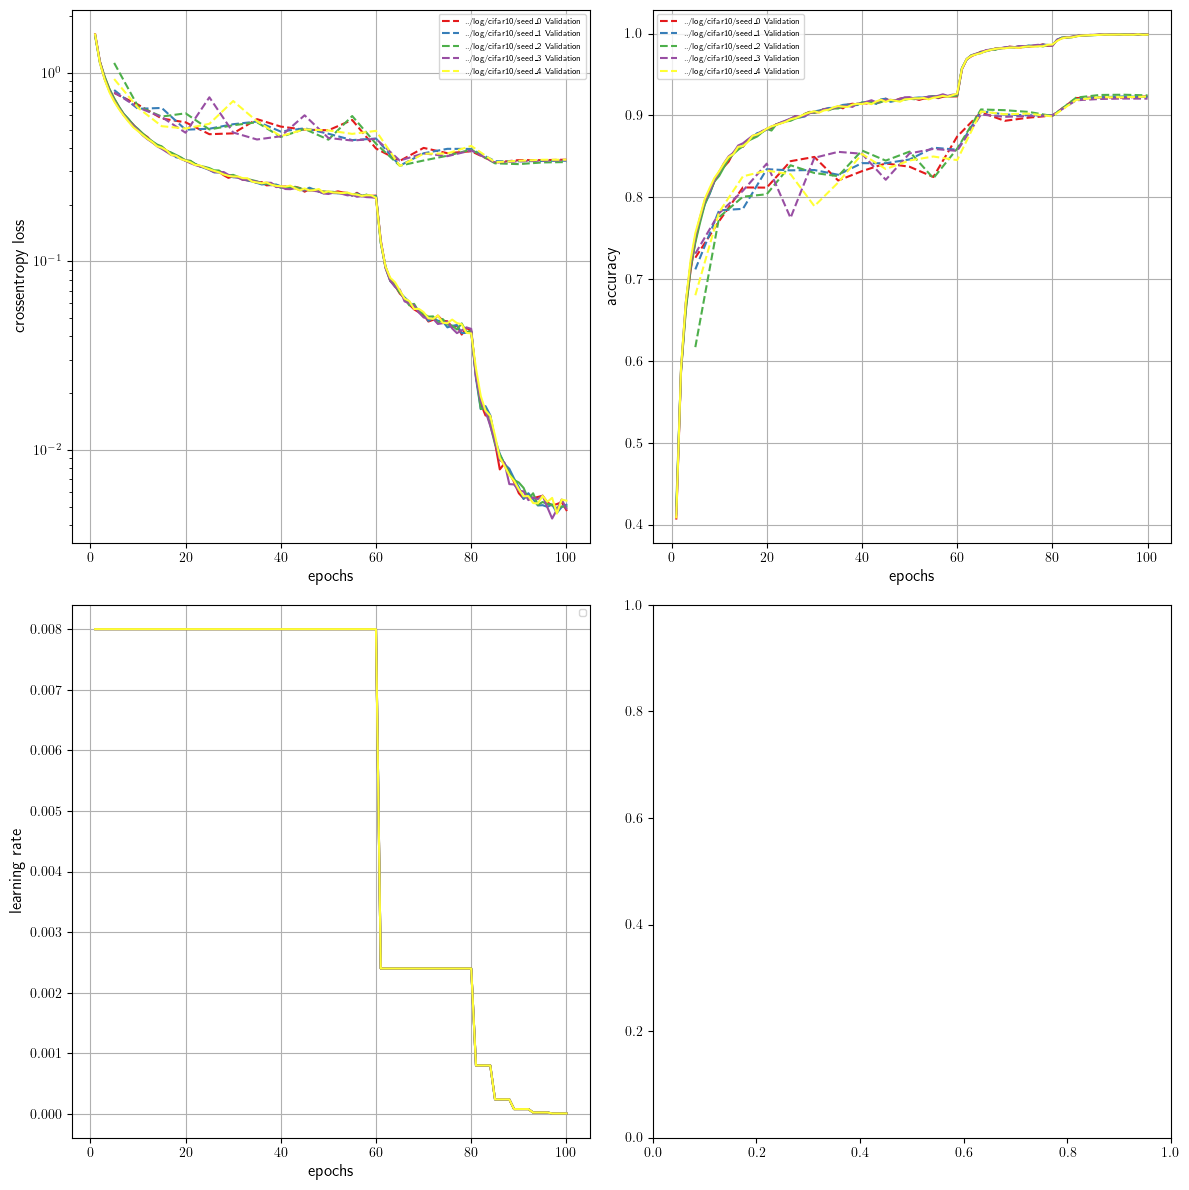

In [4]:
log_path = '../log/cifar10'
runids = [os.path.join(log_path, name) for name in sorted(os.listdir(log_path)) if os.path.isdir(os.path.join(log_path, name))]
fig = plot_training_history(runids, [])

# Compute performance metrics

In [5]:
def get_performance_metrics(exp_paths):
    n_class_metric_names = []
    class_metric_names = ['acc']
    single_exp_metrics, combined_exp_metrics = [], []
    single_exp_df, combined_exp_df = [], []

    #single model performances
    for exp_path in exp_paths:
        #seed_paths = [os.path.join(exp_path, path) for path in os.listdir(exp_path) if os.path.isdir(os.path.join(exp_path, path))]
        single_exp_dict, combined_exp_dict = ev.get_classification_metrics_from_multiple_sources(
            [os.path.join(exp_path, name) for name in sorted(os.listdir(exp_path)) if os.path.isdir(os.path.join(exp_path, name))], 
            exp_path,
            class_metric_names=class_metric_names,
            n_class_metric_names=n_class_metric_names,
            b_ensemble=False,
            b_average_metrics=True, 
            label_of_positive=None, 
            labels=[],
        )
        single_exp_metrics.append(single_exp_dict)
        combined_exp_metrics.append(combined_exp_dict)
        single_exp_df.append(ev.get_single_exp_df(single_exp_dict, n_class_metric_names))
        combined_exp_df.append(ev.get_combined_exp_df(combined_exp_dict, n_class_metric_names))

    single_exp_df = pd.concat(single_exp_df)
    combined_exp_df = pd.concat(combined_exp_df)
    #single_exp_df.sort_values('acc', ascending=False, inplace=True)
    #combined_exp_df.sort_values('acc', ascending=False, inplace=True)
    
    return single_exp_df, combined_exp_df, single_exp_metrics, combined_exp_metrics

def evaluate(path: str, save: bool = True, verbose: bool = False):
    exp_paths = [os.path.join(path, name) for name in sorted(os.listdir(path)) if os.path.isdir(os.path.join(path, name))]
    single_exp_df, combined_exp_df, single_exp_metrics, combined_exp_metrics = get_performance_metrics(exp_paths)
    if save:
        prefix = path.replace("../","").replace("/","_")
        single_exp_df.to_csv(os.path.join(RESULTPATH, prefix + "_single_experiment_results.csv"))
        combined_exp_df.to_csv(os.path.join(RESULTPATH, prefix + "_combined_experiment_results.csv"))
    if verbose:
        print("single experiment performance")
        print(single_exp_df)
        print("combined experiment performance")
        print(combined_exp_df)

def evaluate_validation_from_dat_files(path: str, save: bool = True, verbose: bool = False):
    exp_paths = [os.path.join(path, name) for name in sorted(os.listdir(path)) if os.path.isdir(os.path.join(path, name))]
    single_exp_df, combined_exp_df = get_performance_metrics_from_dat_files(exp_paths)
    if save:
        prefix = path.replace("../","").replace("/","_")
        single_exp_df.to_csv(os.path.join(RESULTPATH, prefix + "_single_experiment_results.csv"))
        combined_exp_df.to_csv(os.path.join(RESULTPATH, prefix + "_combined_experiment_results.csv"))
    if verbose:
        print("single experiment performance")
        print(single_exp_df)
        print("combined experiment performance")
        print(combined_exp_df)

def get_performance_metrics_from_dat_files(exp_paths):
    single_exp_dfs, combined_exp_dfs = [], []
    
    for exp_path in exp_paths:
        seed_paths = [os.path.join(exp_path, name) for name in sorted(os.listdir(exp_path)) if os.path.isdir(os.path.join(exp_path, name))]
        accuracies = []
        for seed_path in seed_paths:
            data = ev.load_log_data(os.path.join(seed_path, "validation.dat"))
            accuracies.append(data["correct"].iloc[-1])
        df_single_exp = pd.DataFrame({"id" : seed_path, "accuracy" : accuracies})
        single_exp_dfs.append(df_single_exp)
        accuracy_mean = df_single_exp["accuracy"].mean()
        accuracy_std = df_single_exp["accuracy"].std()
        combined_exp_dfs.append(pd.DataFrame({"id" : [seed_path], 'accuracy_mean' : [accuracy_mean], 'accuracy_std' : [accuracy_std]}))

    single_exp_df = pd.concat(single_exp_dfs)
    combined_exp_df = pd.concat(combined_exp_dfs)
    return single_exp_df, combined_exp_df


In [6]:
evaluate('../log')